In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings
DATA_PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
WORKING_DIR = '/kaggle/input/rsna-2024-train/'
CANDIDATE_DIR = '/kaggle/input/rsna-2024-train-candidate-list/'

import pydicom
import numpy as np
from PIL import Image
from random import randint
from torch.utils.data import DataLoader
import pickle
from pathlib import Path
from collections import namedtuple


LUMBAR_LABEL_MAPPING = {"l1_l2":0,"l2_l3":1,"l3_l4":2,"l4_l5":3,"l5_s1":4}
CONDITION_MAPPING = {}

DATASET_SELECTION = 'axial'

In [2]:
train_candidates = pd.read_csv(WORKING_DIR+'train_candidates.csv')
sagittal_t1 = train_candidates[train_candidates['series_description']=='Sagittal T1']
sagittal_t2 = train_candidates[train_candidates['series_description'].isin(['Sagittal T2/STIR'])]
axial = train_candidates[train_candidates['series_description'].isin(['Axial T2'])]
sagittal = train_candidates[train_candidates['series_description'].isin(['Sagittal T1','Sagittal T2/STIR'])]
datasets = {'sagittal_t1':sagittal_t1, 'sagittal_t2': sagittal_t2, 'sagittal':sagittal, 'all':train_candidates, 'axial': axial}

### Datasets (Region of interest derived from coordinates) 

Components:
- CandidateList: list of instances with valid coordinates and their labelling info
- Region of interest calculation: crude bounding box calculation from coordinates
    - cache the data
- Return: Image, Label (severity)

In [3]:
from collections import namedtuple
import functools
import datetime
from torch.utils.data import Dataset
import random
candidate_info_tuple = namedtuple(
    'candidate_info_tuple',
    'row_id, study_id, series_id, instance_number, has_centres, centre_xy, severity, img_path, width_bbox, height_bbox'
)
SEVERITY_MAPPING = {"Normal/Mild":0,"Moderate":1,"Severe":2}
SEVERITY_WEIGHTING = {0:1.0,1:2.0,2:4.0}

In [4]:
@functools.lru_cache(1, typed=True)
def get_candidate_list(selection='all',_height: tuple=(40,50), _width: tuple=(40,60)):
    
    candidate_dataset = datasets[selection]
    
    candidate_list = []
    
    for ndx, instance in enumerate(candidate_dataset.itertuples(name='Candidate')):
        
        try:
            img_path = f"{DATA_PATH}/train_images/{instance.study_id}/{instance.series_id}/{int(instance.instance_number)}.dcm" 

            if not os.path.exists(img_path):
                print(f"Path not found {img_path}")
                continue

            if ndx % 10000 == 0 and ndx !=0:
                print(f"{datetime.datetime.now()}, {ndx} records processed")
            
            # Create random sized bboxes, between reasonable ranges TODO make this smarter based on pixel size etc.
            random.seed(ndx)
            height = randint(*_height)                
            width = randint(*_width)

            candidate_list.append(
                candidate_info_tuple(
                    row_id = instance.row_id,
                    study_id = instance.study_id, 
                    series_id = instance.series_id, 
                    instance_number = instance.instance_number, 
                    centre_xy = (instance.x, instance.y), 
                    severity = SEVERITY_MAPPING[instance.target], 
                    img_path = img_path,
                    width_bbox=width,
                    height_bbox=height,
                    has_centres=True
         
                )
            )
        except Exception as e:
            print(instance)
            raise e

    return candidate_list

In [5]:
@functools.lru_cache(1, typed=True)
def get_image(path):
    return pydicom.dcmread(path)

In [6]:
def group_proportions(group):
    group_len = len(group)
    proportions = {sev_key: len(group[group['target'] == sev_key]) / group_len for sev_key in SEVERITY_MAPPING.keys()}
    proportions['study_id'] = group.name
    return pd.Series(proportions)

datasets[DATASET_SELECTION].loc[:,'study_id'] = datasets[DATASET_SELECTION].loc[:,'study_id'].astype(str)

grouped = datasets[DATASET_SELECTION].groupby('study_id')

proportions_df = grouped.apply(group_proportions,include_groups=False).reset_index(drop=True)

# Assuming you want to sort by a specific severity level, e.g., 'mild'
sorted_proportions_df = proportions_df.sort_values(by=['Severe','Moderate','Normal/Mild'], ascending=False)

/tmp/ipykernel_33/1586915582.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['4003253' '4646740' '7143189' ... '4284048608' '4287160193' '4290709089']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  datasets[DATASET_SELECTION].loc[:,'study_id'] = datasets[DATASET_SELECTION].loc[:,'study_id'].astype(str)


In [7]:
@functools.lru_cache(1, typed=True)
def get_roi(img_path, x_centre, y_centre, width = 50, height = 40):
    image = get_image(img_path)
    y_max, x_max = image.pixel_array.shape
    x_left, x_right, y_bot, y_top = int(max(0,x_centre - width//2)), int(min(x_max, x_centre + width//2)), int(max(0, y_centre - height//2)), int(min(y_max, y_centre + height//2))
    roi = image.pixel_array[y_bot:y_top,x_left:x_right]
    return roi.astype(np.uint8)

In [8]:
import cv2

IMG_RESIZE = (416, 416)

def bounding_box_adj(orig_img: np.array, x_centre, y_centre, width, height, img_resize):
    """
    https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format
    
    Box coordinates must be in normalized xywh format (from 0 to 1). If your boxes are in pixels, you should divide x_center and width by 
    image width, and y_center and height by image height. Class numbers should be zero-indexed (start with 0).
    """
    if not img_resize:
        img_resize = orig_img.shape
    
    y_dim = orig_img.shape[0]
    x_dim = orig_img.shape[1]
        
    y_scale = img_resize[0] / y_dim
    x_scale = img_resize[1] / x_dim
    
    # Adjust height/width for OOB coords
    x_centre = x_centre - np.max([x_centre+width/2 - x_dim,0]) - np.min([abs(x_centre-width/2),0])
    y_centre = y_centre - np.max([y_centre+height/2 - y_dim,0]) - np.min([abs(y_centre-height/2),0])
    
    # Scale for resize
    x_centre = x_centre * x_scale
    width = width * x_scale
    y_centre = y_centre * y_scale
    height = height * y_scale
    
    # Scale to 0-1 for YOLO dataset    
    x_centre = x_centre / img_resize[1]
    width = width / img_resize[1]
    y_centre = y_centre / img_resize[0]
    height = height / img_resize[0]
    
    # Return in xywh format
    return x_centre, y_centre, width, height
    
def yolo_preprocess(img: np.array, img_resize: tuple = IMG_RESIZE): 
    """
    """

    # Normalize to the range [0, 255] using the actual max value
    image_2d = img.astype(float)
    image_2d = (np.maximum(image_2d, 0) / image_2d.max()) * 255.0
    image_2d = np.uint8(image_2d)
    
    # Resize image
    resized_image = cv2.resize(image_2d, img_resize, interpolation=cv2.INTER_LINEAR)
    
    return resized_image


In [9]:
candidate_list_path = f"{CANDIDATE_DIR}/candidate_list_{DATASET_SELECTION}.pkl"

if Path(candidate_list_path).exists():
    with open(Path(candidate_list_path),'rb') as f:
        candidate_info_tuple = namedtuple(
            'candidate_info_tuple',
            'row_id, study_id, series_id, instance_number, has_centres, centre_xy, severity, img_path, width_bbox, height_bbox'
        )
        out = pickle.load(f)
        candidate_list, sorted_candidate_list = out['candidate_list'], out['sorted_study_ids']

else:
    candidate_list = get_candidate_list(DATASET_SELECTION,_height=(50,50),_width=(60,60))
    sorted_candidate_list = sorted_proportions_df.study_id.to_list()

2024-11-11 10:53:34.530372, 10000 records processed


**Dump `candidate_list` and `sorted_candidate_list` into pickle file, for use in severity classification training.**

In [10]:
import pickle
# Step 3: Use pickle to save the lists to a file
with open(F'/kaggle/working/candidate_list_{DATASET_SELECTION}.pkl', 'wb') as f:
    pickle.dump({'candidate_list': candidate_list, 'sorted_study_ids': sorted_candidate_list}, f)

### Debugging for given record

In [11]:
# # 1777645381_1438513204
# candidate_list = [i for i in candidate_list if i.study_id == "1777645381" and i.series_id == 1438513204]

## Create Dataset

Create YOLO `Dataset` stratifying against severity of condition.

In [12]:
class LumbarStratifyYOLO(Dataset):
    
    def __init__(self,
                val_stride=0,
                val_set=False,
                study_id=None,
                candidate_list=None,
                transform=None,
                sample: int | None = None,
                rand_bbox: bool = False,
                sorted_candidate_list=None, 
                save_to_drive: bool = False,
                debug_mode: bool = False):
        
        self.sample = sample
        self.rand_bbox = rand_bbox
        self.save_to_drive = save_to_drive
        self.debug_mode = debug_mode
        
        if candidate_list:
            self.candidate_list = candidate_list.copy()
        else:
            self.candidate_list = get_candidate_list().copy()
        
        # Default to a stratified sampled of candidates by study_id (option to provide custom sorted list on other
        # stratifications).
        if sorted_candidate_list:
            self.sorted_candidate_list = sorted_candidate_list.copy()
        else:
            study_ids = np.unique([x.study_id for x in self.candidate_list])
            self.sorted_candidate_list = np.random.shuffle(study_ids)
        
        if study_id:
            self.candidate_list = [x for x in self.candidate_list if x.study_id == study_id]
        
        if val_set:
            assert val_stride > 0, val_stride
            val_study_ids = self.sorted_candidate_list[::val_stride]
            self.candidate_list = [x for x in self.candidate_list if str(x.study_id) in val_study_ids]
            assert self.candidate_list
        elif val_stride > 0:
            del self.sorted_candidate_list[::val_stride]                        
            self.candidate_list = [x for x in self.candidate_list if str(x.study_id) in self.sorted_candidate_list]            
            assert self.candidate_list
    
        self.transform = transform
    
    def __len__(self):
        if self.sample:
            return min(self.sample, len(self.candidate_list))
        else:
            return len(self.candidate_list)
    
    def __getitem__(self,ndx):
        """
        return 
        """
        
        candidate = self.candidate_list[ndx]
        
        # Get full image
        image = get_image(candidate.img_path)      
        
        if self.rand_bbox:
            width = randint(40,60)
            height = randint(50,70)
        else:
            width = candidate.width_bbox
            height = candidate.height_bbox

        resized_image = yolo_preprocess(image.pixel_array, IMG_RESIZE)
        bounding_box_coord = bounding_box_adj(image.pixel_array, candidate.centre_xy[0], candidate.centre_xy[1], width, height, IMG_RESIZE)
        
        if self.debug_mode:
            return resized_image, bounding_box_coord, candidate, image
        else:
            return resized_image, bounding_box_coord, candidate
        

### Examples first
- Adjusted bounding boxes
- Resized image

Examples:
- 1002894806_866293114_4
- 1002894806_801316590_10
- 1777645381_1438513204

In [13]:
ExampleSet = LumbarStratifyYOLO(candidate_list=candidate_list,
                              sorted_candidate_list=sorted_candidate_list,
                              study_id='1777645381',
                               debug_mode=True)


In [14]:
for i in ExampleSet:
    print(i[1])

(0.5596386894075404, 0.5273788150807899, 0.1875, 0.15625)
(0.5596386894075404, 0.5148114901256732, 0.1875, 0.15625)
(0.5578433572710951, 0.5022441651705566, 0.1875, 0.15625)
(0.5578433572710951, 0.5040394973070017, 0.1875, 0.15625)
(0.5596386894075404, 0.505834829443447, 0.1875, 0.15625)
(0.4881539793827073, 0.5023542669321924, 0.1875, 0.15625)
(0.4836696744499721, 0.5068385718649279, 0.1875, 0.15625)
(0.4881539793827073, 0.49338565706672155, 0.1875, 0.15625)
(0.47245891211813346, 0.5047085338643849, 0.1875, 0.15625)
(0.4612481497862948, 0.5024663813980171, 0.1875, 0.15625)


In [15]:
i = ExampleSet[0]
i

(array([[ 0,  1,  1, ...,  1,  1,  1],
        [ 0,  0,  3, ...,  8, 10, 12],
        [ 0,  1,  4, ..., 11, 14, 17],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8),
 (0.5596386894075404, 0.5273788150807899, 0.1875, 0.15625),
 candidate_info_tuple(row_id='1777645381_2330801383_left_subarticular_stenosis_l1_l2', study_id='1777645381', series_id=2330801383, instance_number=3.0, has_centres=True, centre_xy=(179.08438061041292, 168.76122082585275), severity=0, img_path='/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/1777645381/2330801383/3.dcm', width_bbox=60, height_bbox=50),
 Dataset.file_meta -------------------------------
 (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
 (0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
 (0002, 0003) Media Storage SOP Instance UID      UI: 1777645381.1.3
 (0002, 0010) Transfer Syn

In [16]:
# Graphing functions
def coor_on_img(pix_array, coords):
    radius = 20
    color = (255, 0, 0)  # Red color in BGR
    thickness = 2
    IMG = pix_array
    IMG_normalized = IMG
#     IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     # Convert the image from BGR to RGB for correct color display in matplotlib
#     IMG_normalized = cv2.cvtColor(IMG_normalized, cv2.COLOR_BGR2RGB)
    
    for row in coords:
            x_centre, y_centre, width, height = row
            # Calculate the top-left and bottom-right corners of the rectangle
            top_left = (int(x_centre - width // 2), int(y_centre + height // 2))
            bottom_right = (int(x_centre + width // 2), int(y_centre - height // 2))

            # Draw the rectangle
            IMG_normalized = cv2.rectangle(IMG_normalized.copy(), top_left, bottom_right, color, thickness)

    return IMG_normalized



In [18]:
resized_image, bounding_box_coord, candidate, image = i
bbox_coor = bounding_box_adj(image.pixel_array,candidate.centre_xy[0],candidate.centre_xy[1], candidate.width_bbox, candidate.height_bbox, IMG_RESIZE)
coord_list = [(bbox_coor[0]*IMG_RESIZE[1],bbox_coor[1]*IMG_RESIZE[0],bbox_coor[2]*IMG_RESIZE[1],bbox_coor[3]*IMG_RESIZE[0])]

In [19]:
bounding_box_adj(image.pixel_array,candidate.centre_xy[0],candidate.centre_xy[1], candidate.width_bbox, candidate.height_bbox, IMG_RESIZE)

(0.5596386894075404, 0.5273788150807899, 0.1875, 0.15625)

In [20]:
(IMG_RESIZE/np.array(image.pixel_array.shape))*np.array(candidate.centre_xy) / IMG_RESIZE

array([0.55963869, 0.52737882])

In [21]:
bbox_coor

(0.5596386894075404, 0.5273788150807899, 0.1875, 0.15625)

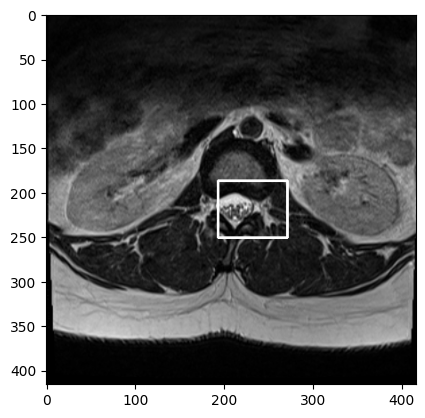

In [22]:
image_out = coor_on_img(resized_image, coord_list)
plt.imshow(image_out, cmap='gray')

In [23]:
image.pixel_array,candidate.centre_xy[0], candidate.centre_xy[1], candidate.width_bbox, candidate.height_bbox, IMG_RESIZE

orig_img=image.pixel_array
x_centre=candidate.centre_xy[0]
y_centre=candidate.centre_xy[1]
width=candidate.width_bbox
height=candidate.height_bbox
img_resize = IMG_RESIZE

## TRAINING: Export to YOLO directory format

In [24]:
TrainSet = LumbarStratifyYOLO(candidate_list=candidate_list,
                              sorted_candidate_list=sorted_candidate_list,
                              val_stride=5,
                              val_set=False,
                              rand_bbox=True)

ValSet = LumbarStratifyYOLO(candidate_list=candidate_list,
                            sorted_candidate_list=sorted_candidate_list,
                            val_stride=5,
                            val_set=True,
                            rand_bbox=True)

# # TODO Full inference set, if coordinates appear then labelling files are created, otherwise it is pure image.
# FullSet = Lumb

In [25]:
for batch in TrainSet:
    image, bounding_box, candidate = batch
    if any([True for i in bounding_box if i>1 or i<0]):
        print("Yep")
        break


In [26]:
yolo_dirs = ["/kaggle/working/yolo_set/images/train/","/kaggle/working/yolo_set/images/val/","/kaggle/working/yolo_set/labels/train/","/kaggle/working/yolo_set/labels/val/"]
for d in yolo_dirs:
    if os.path.exists(d):
        continue
    else:
        os.makedirs(d)

In [27]:
candidate

candidate_info_tuple(row_id='4290709089_3390218084_right_subarticular_stenosis_l5_s1', study_id='4290709089', series_id=3390218084, instance_number=21.0, has_centres=True, centre_xy=(302.87591087443946, 364.627811448991), severity=0, img_path='/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4290709089/3390218084/21.dcm', width_bbox=60, height_bbox=50)

In [28]:
for ndx, batch in enumerate(TrainSet):
    
    image, bounding_box, candidate = batch
    
    image_key = "_".join([str(candidate.study_id),str(candidate.series_id), str(int(candidate.instance_number))]) 
    img_path = f'/kaggle/working/yolo_set/images/train/{image_key}.png'
    label_path = f'/kaggle/working/yolo_set/labels/train/{image_key}.txt'
    
    if isinstance(bounding_box,tuple):
        bounding_box = [bounding_box]
        
    for box in bounding_box:
        x_centre, y_centre, width, height = box
        
        
        if 'axial' in DATASET_SELECTION:
            class_id = 1 if 'right' in candidate.row_id else 0
        else:
            class_id = LUMBAR_LABEL_MAPPING[candidate.row_id[-5:]]
        
        # Prepare label string in YOLO format
        label_line = f"{class_id} {x_centre} {y_centre} {width} {height}\n"

        # Save label file
        with open(label_path, 'a') as f:
            f.write(label_line + '\n')  

    # Save image
    cv2.imwrite(img_path, image)
    
    if ndx%1000 == 0:
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, Processed {ndx} images.")

2024-11-11 10:59:27, Processed 0 images.
2024-11-11 10:59:49, Processed 1000 images.
2024-11-11 11:00:11, Processed 2000 images.
2024-11-11 11:00:32, Processed 3000 images.
2024-11-11 11:00:55, Processed 4000 images.
2024-11-11 11:01:17, Processed 5000 images.
2024-11-11 11:01:39, Processed 6000 images.
2024-11-11 11:02:02, Processed 7000 images.
2024-11-11 11:02:24, Processed 8000 images.
2024-11-11 11:02:45, Processed 9000 images.
2024-11-11 11:03:07, Processed 10000 images.
2024-11-11 11:03:28, Processed 11000 images.
2024-11-11 11:03:50, Processed 12000 images.
2024-11-11 11:04:12, Processed 13000 images.
2024-11-11 11:04:35, Processed 14000 images.
2024-11-11 11:04:57, Processed 15000 images.


In [29]:
for ndx, batch in enumerate(ValSet):
    
    image, bounding_box, candidate = batch
    
    image_key = "_".join([str(candidate.study_id),str(candidate.series_id), str(int(candidate.instance_number))]) 
    img_path = f'/kaggle/working/yolo_set/images/val/{image_key}.png'
    label_path = f'/kaggle/working/yolo_set/labels/val/{image_key}.txt'
    
    if isinstance(bounding_box,tuple):
        bounding_box = [bounding_box]
        
    for box in bounding_box:
        x_centre, y_centre, width, height = box
        
        if 'axial' in DATASET_SELECTION:
            class_id = 1 if 'right' in candidate.row_id else 0
        else:
            class_id = LUMBAR_LABEL_MAPPING[candidate.row_id[-5:]]        
        # Prepare label string in YOLO format
        label_line = f"{class_id} {x_centre} {y_centre} {width} {height}\n"

        # Save label file
        with open(label_path, 'a') as f:
            f.write(label_line + '\n')  

    # Save image
    cv2.imwrite(img_path, image)
    
    if ndx%1000 == 0:
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, Processed {ndx} images.")

2024-11-11 11:05:06, Processed 0 images.
2024-11-11 11:05:36, Processed 1000 images.
2024-11-11 11:06:05, Processed 2000 images.
2024-11-11 11:06:30, Processed 3000 images.


In [30]:
# Save to ZIP
import shutil
DIRECTORY_TO_ZIP = "/kaggle/working/yolo_set"
shutil.make_archive(f"/kaggle/working/yolo_{DATASET_SELECTION}", 'zip', DIRECTORY_TO_ZIP)


'/kaggle/working/yolo_axial.zip'

In [31]:
from IPython.display import FileLink
FileLink(f'yolo_{DATASET_SELECTION}.zip')

/kaggle/working/yolo_axial.zip